In [5]:
# Token analysis for ITL Agent Log Processing Scripts
# Version: Verification Experiments Analysis
# Apr 2023

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path

# Must set to this to path for your system
# Assumes there is a experiment_name directory at this path with subdirectory raw_data and output
# (If you are running on the data included in the repo, the substructure should be fine)
BASE_DIR = Path('/TODO/INSERT/PATH/TO/REPO/ROOT')

# Sanity check your specified path
assert BASE_DIR.is_dir(), "You need to set BASE_DIR to the path to this repository; the specified path does not exist or is not a directory."

os.chdir(BASE_DIR / 'DataAnalysisScripts' / 'ITLAgent-LogProcessingScripts')

AssertionError: You need to set BASE_DIR to the path to this repository; the specified path does not exist or is not a directory.

In [2]:
# Experiment specific variables
# experiment_name = "TidyKitchenTask"
#experiment_name = "Verification-AtypicalObjects"
#experiment_name = "Verification-AtypicalObjects"
# experiment_name = "GroceryTask"
experiment_name = "OfficeTask"

#condition_names = ["Planning", "Instruction", "Plan+LLM", "Inst+LLM", "Combined_d2", "Combined_d4"]
#condition_names = ["Instruction", "Inst+Search", "Search+LLM", "Instruction+LLM", "Inst+Search_2+LLM", "Inst+Search_4+LLM"]
#condition_names = ["lm_tree_repair_select18Apr","duplicate_test_condition"]
#condition_names = ["lm_human","lm_human_tree","lm_human_tree_eval","lm_human_tree_select","lm_human_tree_eval_select","lm","lm_tree","lm_tree_eval","lm_tree_select","lm_tree_eval_select"]
#condition_names = ["lm_human", "Rlm_tree_eval_select_run1", "Rlm_tree_eval_select_run2", "Rlm_tree_eval_select_run3","Rlm_tree_eval_select_run4", "Rlm_tree_eval_select_run5"]
#condition_names = ["lm_tree_eval_select", "extra_test_data"]
#condition_names = ["lm_human","lm_human_tree_eval_select","lm","lm_tree","lm_tree_eval","lm_tree_select","lm_tree_eval_select"]
condition_names = ["TBP","TBP+O","ST","STS","STAR","STARS","STARS+O"]

condition_names.reverse()
#condition_names = ["all_conditions_depth4"]

# Note that the data files are now organized differently for the IJCAI experiment, with the experiment at the root
output_directory =  "./" + experiment_name + "/output/"
data_path = "./" + experiment_name + "/raw_data/" 

if not Path(experiment_name).is_dir():
    raise ValueError(f"Experiment directory does not exist: {experiment_name}")
Path(output_directory).mkdir(exist_ok=True)
if not Path(data_path).is_dir():
    raise ValueError(f"Experiment raw data directory does not exist: {data_path}")

# file names we process
token_counts = "tokens.txt"



In [12]:
# Test only
# Use this to explore the data for a particular condition or subset of conditions

for condition in condition_names:
    filepath = data_path + condition + "/"
    
    # Read the data
    token_data = pd.read_csv(filepath+token_counts, sep=';')

    # Summarize the data
    grouped_by_prompt_type = token_data.groupby('prompt type').sum().reset_index()
    grouped_by_object_handle = token_data.groupby('object handle').sum().reset_index()
    
    

/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_24415/2063283584.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_prompt_type = token_data.groupby('prompt type').sum().reset_index()
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_24415/2063283584.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_object_handle = token_data.groupby('object handle').sum().reset_index()
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_24415/2063283584.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

In [13]:
# This function reads in the token file for a given condition and returns two axes/figs
# for the prompt types and objects by expended tokens
#
# It also suppresses tick marks and labels for the right column of figures and all but the last row

def process_file(axs, file_path, condition, prompt_color, completion_color, display_xlabels):
    # Given that we read the files in 1-by-1, these must be estimated for each experiment. 
    # Needed to ensure that the y-axis for the plots does not change from plot to plot
    y_max_prompts = 50000
    y_max_objects = 15000
    
    # Read the data
    data = pd.read_csv(file_path, sep=';')
    
    prompt_types = ["initial_prompt","recurse_prompt","repair_prompt","repair_recurse_prompt","selection_prompt"]
    
    # Summarize the data
    grouped_by_prompt_type = data.groupby('prompt type').sum().reset_index()

    # Make sure all the prompt groups are included in the resulting df
    for prompt in prompt_types:
        if not (grouped_by_prompt_type['prompt type']==prompt).any():
            #print("Adding missing", prompt, " to ", condition)
            grouped_by_prompt_type = grouped_by_prompt_type.append([{"prompt type":prompt,
                                                                     "completion tokens":0,
                                                                     "prompt tokens":0,
                                                                     "total tokens":0}])
    
    # Reorder the data so that there is a fixed order for all conditions regardless of missing prompt types
    grouped_by_prompt_type['prompt type'] = pd.Categorical(grouped_by_prompt_type['prompt type'], categories=prompt_types, ordered=True)
    grouped_by_prompt_type = grouped_by_prompt_type.sort_values('prompt type')
    
    grouped_by_object_handle = data.groupby('object handle').sum().reset_index()

    # Uncomment if you want to look at the raw data
    #print(grouped_by_object_handle.head())
    #print(grouped_by_prompt_type.head())

    # Plot stacked bar charts on the given axes
    for ax, group, xlabel, ymax in zip(axs, [grouped_by_prompt_type, grouped_by_object_handle], 
                                            ['Prompt Type', 'Object Handle'], [y_max_prompts,y_max_objects]):
        x = group.iloc[:, 0]

        ax.bar(x, group['prompt tokens'], label='Prompt Tokens', color=completion_color, hatch="......", edgecolor=prompt_color)
        ax.bar(x, group['completion tokens'], bottom=group['prompt tokens'], label='Completion Tokens', color=prompt_color)

        # These if statements determine which tickmarks/labels are printed
        if display_xlabels:
            ax.set_xlabel(xlabel)
            ax.tick_params(axis='x', rotation=75, labelsize=7)
            if xlabel=="Prompt Type":
                # Remove underscores from the labels and the redundant "prompt"
                prompt_labels = [re.sub("_prompt|_", lambda match: "/" if match.group(0) == "_" else "", label) for label in prompt_types]
                ax.set_xticklabels(prompt_labels)
            else:
                #Object handles
                handle_list = group['object handle']
                # All instances have two digits. This regexp preserves the trailing digit (may not be ideal...)
                handle_labels = [re.sub("1_instance_[0-9]|-", lambda match: " " if match.group(0) == "-" else "", label) for label in handle_list]
                ax.set_xticklabels(handle_labels)
        else:
            ax.set_xticklabels(['' for _ in x])  # Remove xtick labels
        ax.set_ylabel('Tokens')
        ax.set_ylim([0,ymax])
        ax.set_title(f'{condition}: Stacked Bars by {xlabel}')
        ax.legend()
    
    summary = [{"condition":condition, 
               "prompt tokens":grouped_by_prompt_type["prompt tokens"].sum(),  
               "completion tokens":grouped_by_prompt_type["completion tokens"].sum() }]
    return summary 
    # print (condition, grouped_by_prompt_type["completion tokens"].sum(), grouped_by_prompt_type["prompt tokens"].sum())


/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_24415/4079552420.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_prompt_type = data.groupby('prompt type').sum().reset_index()
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_24415/4079552420.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_by_prompt_type = grouped_by_prompt_type.append([{"prompt type":prompt,
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_24415/4079552420.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_by_prompt_type = grouped_by_prompt_type.append([{"prompt type":prompt,
/var/folders

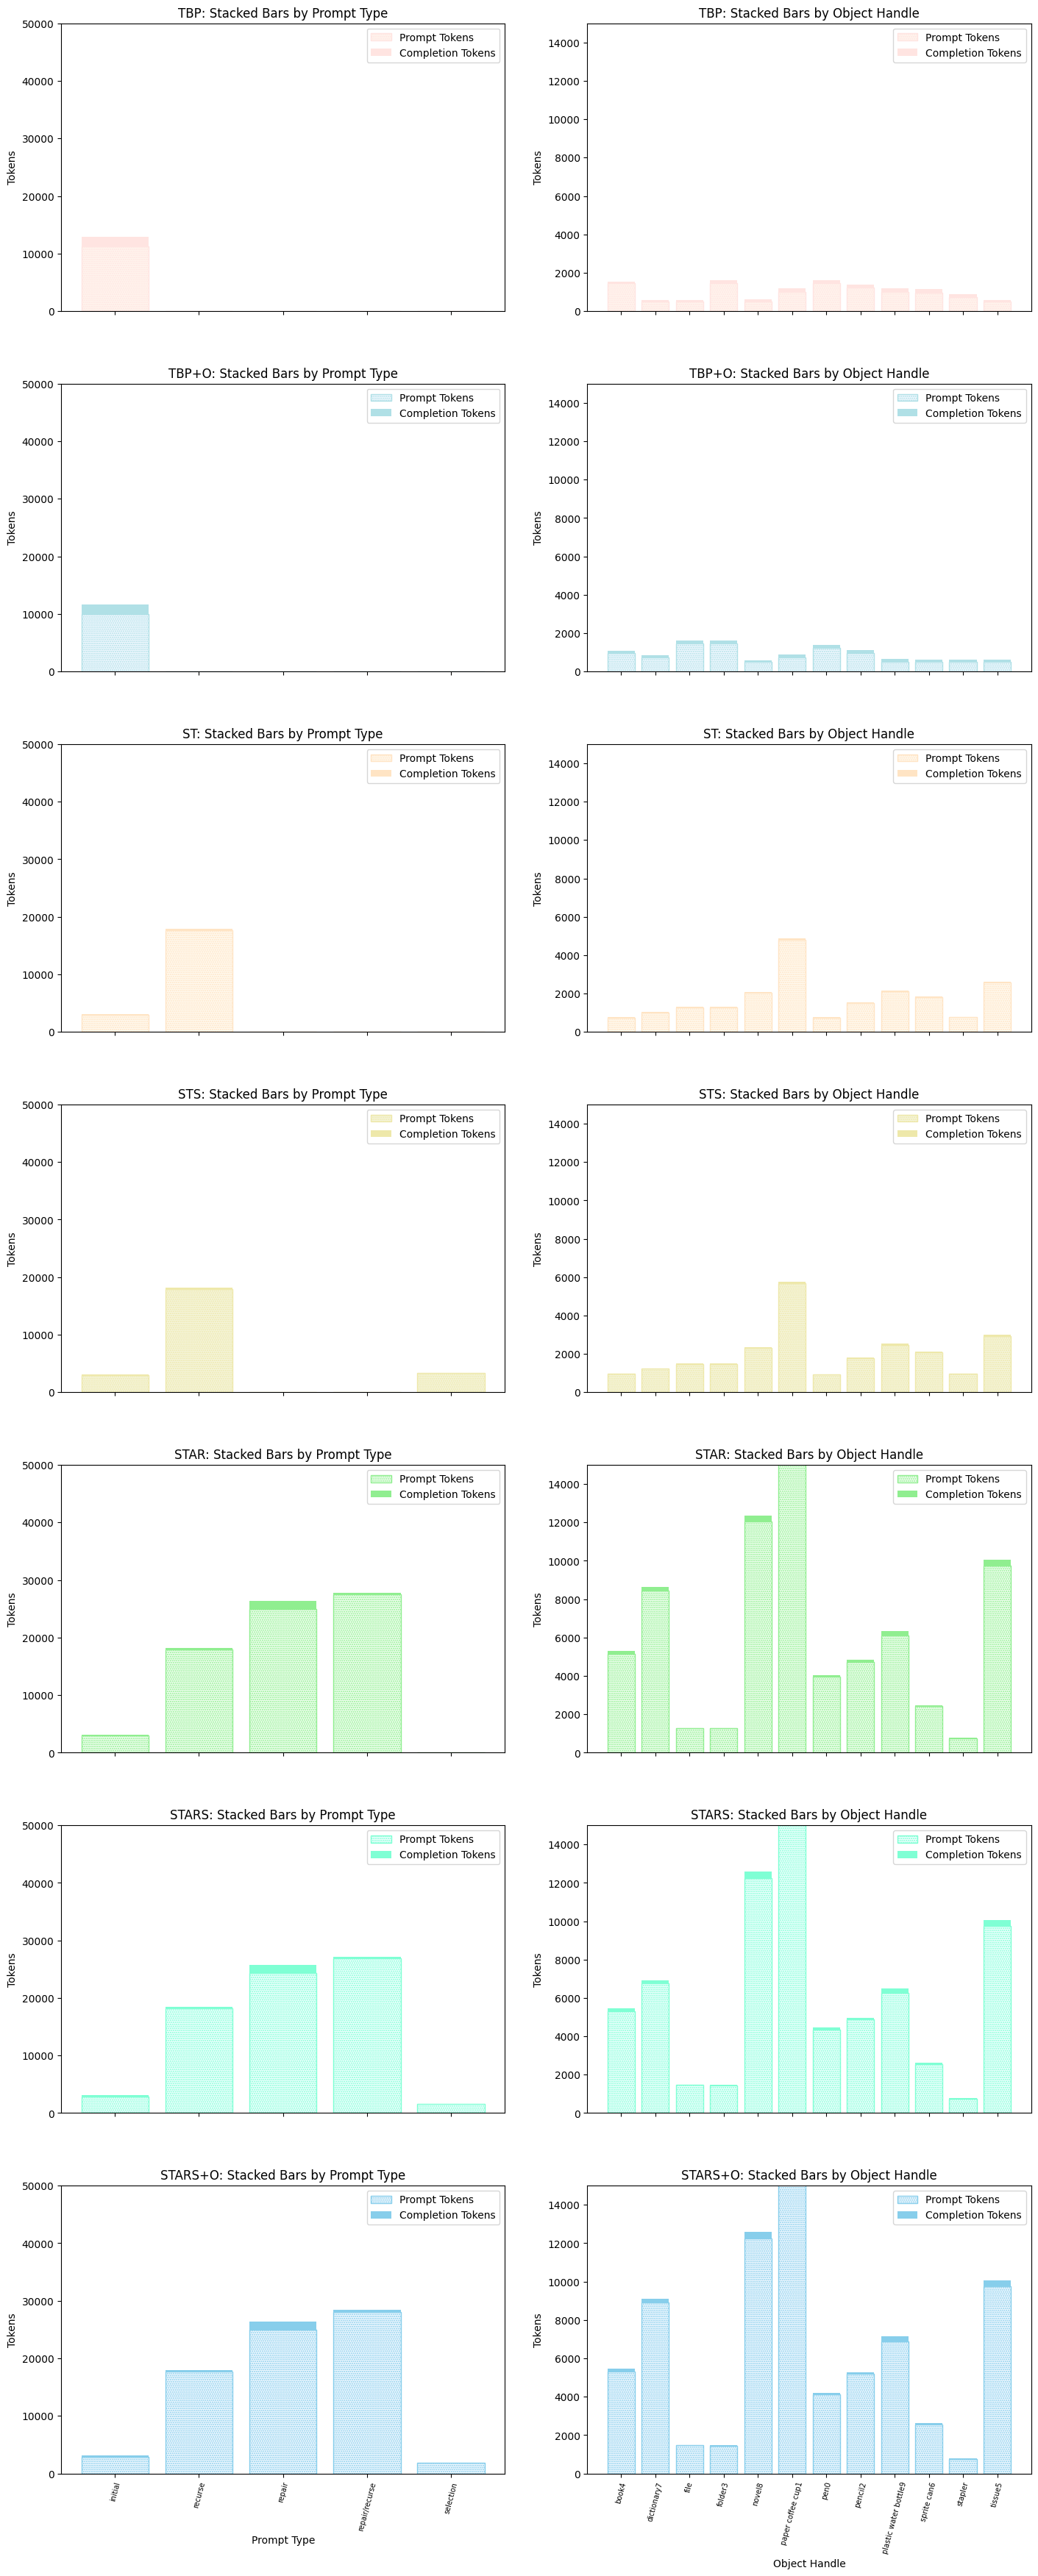

In [14]:
# Primary output plots for STARS paper/submission
save_plot = True
#save_plot = False
plot_title = experiment_name + "TokenCountDetailed" + ''.join(condition_names)

total_summary=pd.DataFrame()

# This graph gets built in reverse order (top to bottom) from the summary matrix (which is bottom to top)
# Make a copy of the conditions list so that reversing doesnt change the original list
reverse_conditions = condition_names.copy()
reverse_conditions.reverse()

# Colors
#bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle", "palegoldenrod", "navajowhite", "lemonchiffon", "lightseagreen", "yellowgreen"]
#bar_colors = ["plum", "powderblue", "palegoldenrod", "navajowhite", "aquamarine", "yellowgreen", "midnightblue" ]
#bar_colors.reverse()
#comp_bar_colors = ["purple", "darkblue", "darkgoldenrod", "orange", "mediumaquamarine", "olive", "skyblue"]
#comp_bar_colors = ["darkblue",  "midnightblue", "purple", "cadetblue", "mediumorchid", "darkgoldenrod", "orange", "darkkhaki", "mediumaquamarine", "olive"]
#comp_bar_colors.reverse()
bar_colors = ["mistyrose",
              "powderblue",  
              "bisque", "palegoldenrod", "lightgreen", "aquamarine",
              "skyblue"]

comp_bar_colors = ["seashell",  "aliceblue", "floralwhite", "beige", "honeydew", "azure", "aliceblue"]


n_files = len(condition_names)
#print(n_files,condition_names)

fig, axes = plt.subplots(n_files, 2, figsize=(15, n_files * 5))
fig.tight_layout(pad=5)

for i, condition in enumerate(reverse_conditions):
    file_path = data_path + condition + "/" + token_counts
    display_xlabels = i == n_files - 1  # Display xlabels only for the bottom row
    totals = process_file((axes[i,0], axes[i,1]), file_path, condition, bar_colors[i], comp_bar_colors[i], display_xlabels)
    total_summary = total_summary.append(totals)

if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')


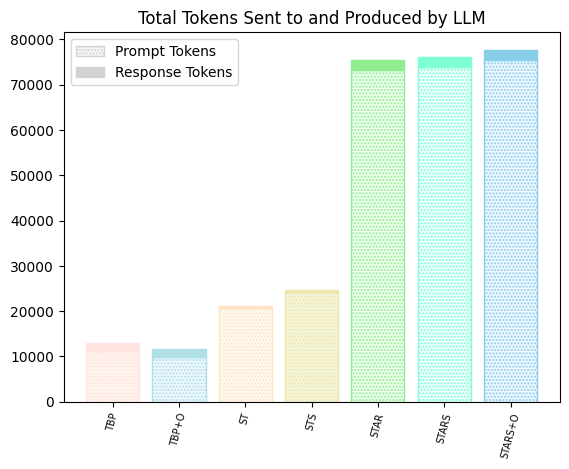

In [15]:
from matplotlib.patches import Patch
#print(total_summary)
# Primary output plots for CORL23 submission
save_plot = True
#save_plot = False
plot_title = experiment_name + "TokenCountsOverallSummary" + ''.join(condition_names)

comp_bar_colors = ["seashell",  "aliceblue", "floralwhite", "beige", "honeydew", "azure", "aliceblue"]

fig, ax = plt.subplots()

#ax.set_title("Total Tokens Sent to and Produced by LLM:"+experiment_name)
ax.set_title("Total Tokens Sent to and Produced by LLM")
ax.bar(total_summary.condition, total_summary['prompt tokens'],  label='Prompt Tokens', color=comp_bar_colors, hatch=["....."], edgecolor=bar_colors)
ax.bar(total_summary.condition, total_summary['completion tokens'],  bottom=total_summary['prompt tokens'], label='Completion Tokens', color=bar_colors,edgecolor=bar_colors)
ax.tick_params(axis='x', rotation=75, labelsize=7)

rea = Patch(color="whitesmoke")
rea.set_edgecolor("lightgray")
rea.set_hatch('.....')
sit = Patch(color="lightgray")
ax.legend(labels=['Prompt Tokens', 'Response Tokens'], handles=[rea,sit],loc="upper left",fontsize=10)




if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')
